In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.image as mgimg
from scipy.stats import binned_statistic

In [2]:
UnitVelocity_in_cm_per_s = 1e5		
UnitVelocity_in_km_per_s = UnitVelocity_in_cm_per_s / 1e5
UnitLength_in_cm = 3.085678e18 	# pc
UnitLength_in_pc = UnitLength_in_cm / 3.085678e18
UnitMass_in_g = 1.989e31		# 0.01 solar masses
UnitMass_in_Msun = UnitMass_in_g / 1.989e33

yr_to_sec = 60 * 60 * 24 * 365
sec_to_yr = 1 / yr_to_sec
cm_to_km = 1 / 1e5
cm_to_pc = 1 / 3.085678e18
UnitEnergy_in_erg = UnitMass_in_g * UnitVelocity_in_cm_per_s**2
UnitDensity_in_cgs = UnitMass_in_g / UnitLength_in_cm**3
UnitTime_in_s = UnitLength_in_cm / UnitVelocity_in_cm_per_s
UnitTime_in_yr = UnitTime_in_s * sec_to_yr

kB_SI = 1.38e-23 #J/K
kB_cgs = kB_SI * 1e7

X_H = 0.76 # hydrogen mass fraction
gamma = 5/3
m_p = 1.67e-24 # proton mass in g

In [22]:
# Load Data

def LoadDataFromHDF(folder, timeStep, dataName, debugOn = False):
    with h5py.File(folder+"/snap_"+str(timeStep).zfill(3) +".hdf5", "r") as hdf:
        data = np.array(hdf.get("PartType0/"+dataName))
        
    if(debugOn):
        print("max "+dataName+": " + str(np.max(data)))
        print("min "+dataName+": " + str(np.min(data)))
        
    return data

# Compute Variables

def T(internalEnergy, electronAbundance): #input in codeunits output in Kelvin
    x_e = electronAbundance
    u = internalEnergy
    
    my = 4/(1 + 3 * X_H + 4 * X_H * x_e) * m_p # meanMolecularWeight
    T = (gamma - 1) * u / kB_cgs * UnitEnergy_in_erg / UnitMass_in_g * my
    return T


def GetTemperatures(folder, timeStep, debugOn = False):
    energies = LoadDataFromHDF(folder, timeStep, "InternalEnergy")
    electronAbundance = LoadDataFromHDF(folder, timeStep, "ElectronAbundance")
    
    temperatures = T(energies, electronAbundance)
    
    if(timeStep == 0):
        print("initial temperature: " + str(temperatures[0]) + "K")
    if(debugOn):
        print("max temp: " + str(np.max(temperatures)))
        print("min temp: " + str(np.min(temperatures)))
    
    return temperatures
    
    
def GetAbsoluteVelocities(folder, timeStep):
    velocities = LoadDataFromHDF(folder, timeStep, "Velocities")
    absoluteVelocities = np.sqrt((velocities*velocities).sum(axis=1))
    return absoluteVelocities


def GetRadialDistances(coos):
    radDists = np.sqrt( (coos[:,0]-boxSize/2)**2 + (coos[:,1]-boxSize/2)**2 + (coos[:,2]-boxSize/2)**2 )
    return radDists

def GetRadialProfile(coos, values, bins, stat = 'mean'):
    profile = np.zeros(len(bins))
    radDists = GetRadialDistances(coos)
    
    profile, binsOut, _ = binned_statistic(radDists, values, statistic=stat, bins = bins)
    
    return profile



    
def PlotData2DHist(ax, x, y, data, vmin, vmax, cbarLabel, title, bins=64):
    ax.set_aspect( 1 )
    hh = ax.hist2d(x, y, weights=data, bins=bins, vmin = vmin, vmax = vmax)
    
    if len(plt.gcf().axes) < 2: # check if there is a cbar already
        cbar = plt.colorbar(hh[3], ax=ax)
        cbar.set_label(cbarLabel, rotation=270,x=-10)
        cbar.ax.yaxis.set_label_coords(6, 0.5)
       # cbar.set_clim(vmin=0,vmax=30000)
    # ScalarMappable.get_clim(vmin=0,vmax=250000)
        cbar.draw_all() 
    
    ax.set_title(title)
    ax.set_xlabel("[pc]")
    ax.set_ylabel("[pc]")
    ax.set_xlim(0,boxSize)
    ax.set_ylim(0,boxSize)
    
    
def PlotDataRadialProfile(ax, coos, data, profileBinAmount, yLabel, title):
    bins = np.linspace(0,boxSize,profileBinAmount)
    profile = GetRadialProfile(coos, data, bins)
    ax.plot(bins[:-1]+boxSize/profileBinAmount/2, profile)
    ax.set_title(title)
    ax.set_xlabel("distance from center[pc]")
    ax.set_ylabel(yLabel)
    ax.set_yscale("log")
    
def PlotDataHist(ax, data, xLabel, title):
    ax.hist(data)
    ax.set_title(title)
    ax.set_xlabel(xLabel)
    ax.set_ylabel("counts")
    ax.set_yscale("log")
    

def MakeTemperaturePlots(folder, timeStep, axs, radProfileBinAmount, debugOn):
    
    temperatures = GetTemperatures(folder, timeStep, debugOn)
    coos = LoadDataFromHDF(folder, timeStep, "Coordinates")
    
    timeOfThisSnapShotInYears = timeStep * TimeBetSnapshot_in_unit_time * UnitTime_in_yr
    
    # hist2d
    hist2dTitle = "Temperature distribution after "+ str(int(timeOfThisSnapShotInYears)) + " years"
    PlotData2DHist(ax = axs[0], x = coos[:,0], y = coos[:,1], data = temperatures, vmin = 0, vmax = 1e9, cbarLabel = 'temperature [K]', title = hist2dTitle)
    
    # radial profile
    radProfileTitle = "radial profile of Temperature after "+ str(int(timeOfThisSnapShotInYears)) + " years"
    PlotDataRadialProfile(axs[1], coos, temperatures, radProfileBinAmount, yLabel = "temperature [K]", title = radProfileTitle)
    
    # histogram
    histTitle = "temperatures after "+ str(int(timeOfThisSnapShotInYears)) + " years"
    PlotDataHist(axs[2], temperatures, xLabel = "temperature [K]", title = histTitle)
    
    
    
def MakeDensityPlots(folder, timeStep, axs, radProfileBinAmount, debugOn):
    
    densities = LoadDataFromHDF(folder, timeStep, "Density", debugOn)
    coos = LoadDataFromHDF(folder, timeStep, "Coordinates")
    
    numberdensities_in_cgs = densities * UnitDensity_in_cgs / m_p
    numberdensities_in_cgs_scaled = numberdensities_in_cgs / 1e3
    
    timeOfThisSnapShotInYears = timeStep * TimeBetSnapshot_in_unit_time * UnitTime_in_yr
    
    # hist2d
    hist2dTitle = "Density distribution after "+ str(int(timeOfThisSnapShotInYears)) + " years"
    PlotData2DHist(ax = axs[0], x = coos[:,0], y = coos[:,1], data = numberdensities_in_cgs_scaled, vmin = 0, vmax = 1, cbarLabel = 'numberdensity [1e3/cm^3]', title = hist2dTitle)
    
    # radial profile
    radProfileTitle = "radial profile of density after "+ str(int(timeOfThisSnapShotInYears)) + " years"
    PlotDataRadialProfile(axs[1], coos, numberdensities_in_cgs, radProfileBinAmount, yLabel = "density [1/cm^3]", title = radProfileTitle)
    
    
    # histogram
    histTitle = "Densities after "+ str(int(timeOfThisSnapShotInYears)) + " years"
    PlotDataHist(axs[2], numberdensities_in_cgs, xLabel = "density [1/cm^3]", title = histTitle)
    
    
def MakeVelocityPlots(folder, timeStep, axs, radProfileBinAmount, debugOn):
    
    coos = LoadDataFromHDF(folder, timeStep, "Coordinates")
    absVelocities = GetAbsoluteVelocities(folder, timeStep)
    absVelocities_in_km_per_s = absVelocities * UnitVelocity_in_km_per_s
    
    timeOfThisSnapShotInYears = timeStep * TimeBetSnapshot_in_unit_time * UnitTime_in_yr
    
    x = coos[:,0]
    y = coos[:,1]
    
    # hist2d
    hist2dTitle = "absolute Veloctiy distribution after "+ str(int(timeOfThisSnapShotInYears)) + " years"
    PlotData2DHist(ax = axs[0], x = coos[:,0], y = coos[:,1], data = absVelocities_in_km_per_s, vmin = 0, vmax = 1e5, cbarLabel = 'Velocity [cm/s]', title = hist2dTitle)
    
    # radial profile
    radProfileTitle = "radial profile of absolute Veloctiy after "+ str(int(timeOfThisSnapShotInYears)) + " years"
    PlotDataRadialProfile(axs[1], coos, absVelocities_in_km_per_s, radProfileBinAmount, yLabel = "absolute velocity [km/s]", title = radProfileTitle)
    
    # histogram
    histTitle = "absolute Velocties after "+ str(int(timeOfThisSnapShotInYears)) + " years"
    PlotDataHist(axs[2], absVelocities_in_km_per_s, xLabel = "absolute velocity [km/s]", title = histTitle)
    
def MakeMultiPlot(folder, timeStep, radProfileBinAmount, saveFolder, debugOn): 
    
    fig, axs = plt.subplots(3, 3, figsize=(20,30))
    
    MakeTemperaturePlots(folder, timeStep, axs[:,0], radProfileBinAmount, debugOn)
    MakeDensityPlots(folder, timeStep, axs[:,1], radProfileBinAmount, debugOn)
    MakeVelocityPlots(folder, timeStep, axs[:,2], radProfileBinAmount, debugOn)
    
    plt.savefig(saveFolder + 'frame_%03d.png' % timeStep)
    plt.close(fig)

In [15]:
##folderPath = "/u/xboecker/run/2_new_create/"
##folderNames = ["28_0_IC_SN_BoxSize_96", "28_4_p0_1", "28_1_n0_10", "28_1_2_n0_100", "28_2_1_cells_64", "28_2_2_cells_32", "28_3_1_stars_10"] # also used for naming the save files
#
#folderPath = "/u/xboecker/run/3_multiple_SNe/"
#folderNames = ["0_1_star", "1_stars_10_linear_spacial_distribution_rad_10", "2_stars_10_linear_temporal_distribution_temp_5kyr", "3_stars_10_linear_spacial_and_temporal_distribution_rad_10pc_temp_5kyr"]
#dataFolders = np.full(len(folderNames),"string long enough so that no entry will be longer than this, because then is would be cut off......................................................................................")
#
#for i in range(len(folderNames)):
#    dataFolders[i] = folderPath+folderNames[i]+"/output"
#    
#
#boxSize = 96
#frameAmount = 40
#frameNbrMultiplier = 1
#TimeBetSnapshot_in_unit_time = 0.002

In [23]:
#folderPath = "/u/xboecker/run/2_new_create/"
#folderName = "28_0_IC_SN_BoxSize_96" # also used for naming the save files

folderPath = "/vera/ptmp/gc/xboecker/run/5_SN_cluster_final/"
folderName = "2_stars_5" # also change saveFolder!

saveFolder = "plots/Cluster/5_stars/"

dataFolder = folderPath+folderName+"/output"
boxSize = 96
frameAmount = 40
frameNbrMultiplier = 10
TimeBetSnapshot_in_unit_time = 0.002

radProfileBinAmount = 50

debugOn = False
skipICs = False
onlyLastSnapshot = False

In [24]:
def animate(timeStep):
    if(skipICs):
        timeStep += 1
        if(timeStep >= frameAmount):
            return
    if(onlyLastSnapshot):
        if(timeStep > 0):
            return
        timeStep = frameAmount-1
    MakeMultiPlot(dataFolder, timeStep, radProfileBinAmount, saveFolder, debugOn)

In [25]:
#calculate and save plots

dh = display(0,display_id=True)

for timeStep in range(frameAmount):
    animate(timeStep)
    dh.update(timeStep)
plt.show()

39

initial temperature: 9.52642678286124K


/tmp/ipykernel_69921/3426866689.py:86: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.set_yscale("log")


# Testing stuff to make a video

In [42]:
#import cv2
import os

os.mkdir("plots/test")

#image_folder = 'plots'
#video_name = 'video.avi'
#
#images = [img for img in os.listdir(image_folder) if img.endswith(".png")]
#frame = cv2.imread(os.path.join(image_folder, images[0]))
#height, width, layers = frame.shape
#
#video = cv2.VideoWriter(video_name, 0, 1, (width,height))
#
#for image in images:
#    video.write(cv2.imread(os.path.join(image_folder, image)))
#
#cv2.destroyAllWindows()
#video.release()

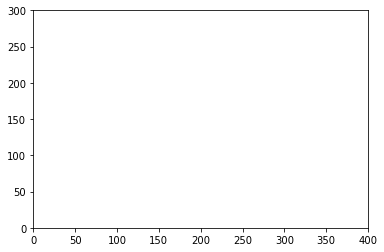

In [40]:
fig, ax = plt.subplots()
plt.axis([0, 400, 0, 300])


def animate(i):
    img = mpimg.imread("plots/multiplot_"+folderName+"_timeStep_"+str(timeStep)+".png")
    #imgplot = plt.imshow(img)
    return img
anim = animation.FuncAnimation(fig, animate,
                               frames=frameAmount)#,
                               #interval=5,
                               #repeat=False)
#ax.set_aspect('equal')

f = r"testMovie.gif" 
writergif = matplotlib.animation.PillowWriter(fps=10) 
anim.save(f, writer=writergif)

plt.show()

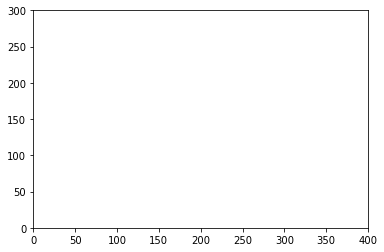

In [34]:
fig, ax = plt.subplots()
plt.axis([0, 400, 0, 300])

timeStep = 5

imobj = ax.imshow(np.zeros((0,0)), aspect='auto',zorder=1)
fname="plots/multiplot_"+folderName+"_timeStep_"+str(timeStep)+".png"
img = mgimg.imread(fname)[-1::-1]
imobj.set_data(img)

plt.show()

Populating the interactive namespace from numpy and matplotlib


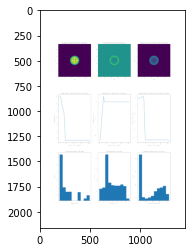

In [37]:
%pylab inline

plt.show()

# Single Image plot

In [21]:
def MakeSingleDensityPlot(folder, timeStep):
    fig, axs = plt.subplots(1, 1, figsize=(10,15))
    axs.set_aspect( 1 )

    densities = LoadDataFromHDF(folder, timeStep, "Density", debugOn)
    coos = LoadDataFromHDF(folder, timeStep, "Coordinates")

    numberdensities_in_cgs = densities * UnitDensity_in_cgs / m_p
    numberdensities_in_cgs_scaled = numberdensities_in_cgs / 1e3

    timeOfThisSnapShotInYears = timeStep * TimeBetSnapshot_in_unit_time * UnitTime_in_yr

    # hist2d
    hist2dTitle = "Density distribution after "+ str(int(timeOfThisSnapShotInYears)) + " years"
    PlotData2DHist(ax = axs, x = coos[:,0], y = coos[:,1], data = numberdensities_in_cgs_scaled, vmin = 0, vmax = 2, cbarLabel = 'numberdensity [1e3/cm^3]', title = hist2dTitle)
    plt.show()

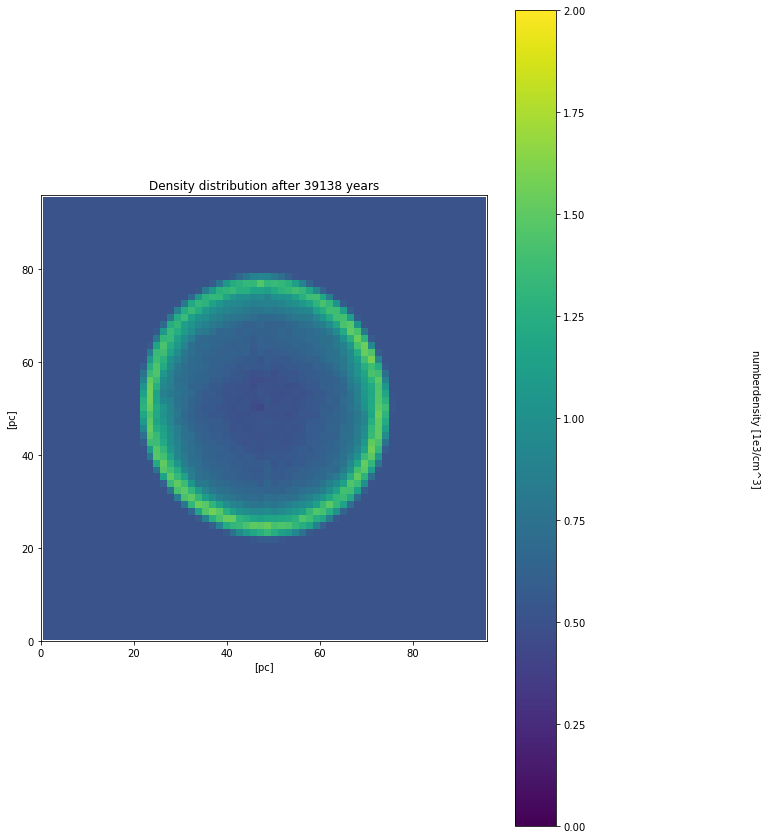

In [26]:
folder = dataFolder
timeStep = 20

MakeSingleDensityPlot(folder, timeStep)